In [13]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


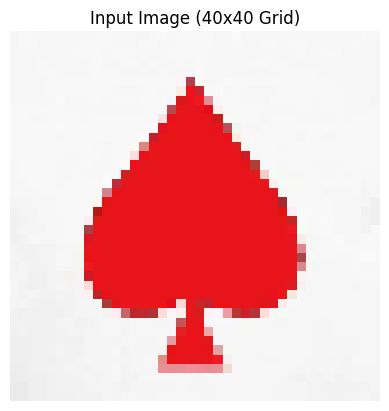

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import time

# 1. Load and Downscale
# We keep the image small (e.g., 40x40 or 50x50) because Python loops are slower than C++ libraries.
image_path = 'helna.jpg' 
img_original = cv2.imread(image_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

h, w = 40, 40 
img = cv2.resize(img_original, (w, h))

# 2. Visualization of Input
plt.imshow(img)
plt.title(f"Input Image ({w}x{h} Grid)")
plt.axis('off')
plt.show()

In [16]:
class MaxFlowGraph:
    """
    A directed graph implementation supporting Max-Flow Min-Cut 
    using the Edmonds-Karp algorithm.
    """

    def __init__(self, num_nodes):
        """
        Initializes the graph structure.
        
        Args:
            num_nodes (int): Total number of nodes in the graph.
        """
        self.V = num_nodes
        # Adjacency matrix could be too large for big images, 
        # so we use an Adjacency List (Dictionary of Dictionaries).
        # graph[u][v] stores the capacity of edge u -> v.
        self.graph = {i: {} for i in range(num_nodes)}
        
        # To store the original graph for checking cuts later if needed
        self.org_graph = {i: {} for i in range(num_nodes)}

    def add_edge(self, u, v, capacity):
        """
        Adds a directed edge with a capacity.
        
        Args:
            u (int): Source node ID.
            v (int): Target node ID.
            capacity (float): The capacity of the link.
        """
        # Forward edge
        self.graph[u][v] = capacity
        self.org_graph[u][v] = capacity
        
        # Backward edge (starts with 0 capacity in residual graph)
        if u not in self.graph[v]:
            self.graph[v][u] = 0

    def bfs(self, s, t, parent):
        """
        Performs Breadth-First Search to find an augmenting path in the residual graph.
        
        Args:
            s (int): Source node ID.
            t (int): Sink node ID.
            parent (dict): A dictionary to store the path trace (child: parent).
            
        Returns:
            bool: True if a path exists from s to t, False otherwise.
        """
        visited = set()
        queue = deque([s])
        visited.add(s)
        parent.clear() # Reset parent map

        while queue:
            u = queue.popleft()

            for v, cap in self.graph[u].items():
                # If not visited and there is residual capacity > 0
                if v not in visited and cap > 0:
                    queue.append(v)
                    visited.add(v)
                    parent[v] = u
                    if v == t:
                        return True
        return False

    def edmonds_karp(self, source, sink):
        """
        Executes the Edmonds-Karp algorithm to find the Maximum Flow.
        
        Args:
            source (int): Source node ID.
            sink (int): Sink node ID.
            
        Returns:
            float: The maximum flow value.
        """
        parent = {}
        max_flow = 0

        # While there is an augmenting path from source to sink
        while self.bfs(source, sink, parent):
            
            # Find the bottleneck capacity along the path found by BFS
            path_flow = float('inf')
            s = sink
            while s != source:
                path_flow = min(path_flow, self.graph[parent[s]][s])
                s = parent[s]

            # Update residual capacities of the edges and reverse edges
            max_flow += path_flow
            v = sink
            while v != source:
                u = parent[v]
                self.graph[u][v] -= path_flow # Reduce forward capacity
                self.graph[v][u] += path_flow # Increase backward capacity
                v = parent[v]

        return max_flow

    def find_min_cut_partition(self, source):
        """
        Identifies the set of nodes reachable from the source in the residual graph
        after Max-Flow has been computed. This defines the Min-Cut.
        
        Args:
            source (int): Source node ID.
            
        Returns:
            set: A set of node IDs belonging to the Source partition (Foreground).
        """
        visited = set()
        queue = deque([source])
        visited.add(source)
        
        while queue:
            u = queue.popleft()
            for v, cap in self.graph[u].items():
                if v not in visited and cap > 0:
                    visited.add(v)
                    queue.append(v)
        
        return visited

In [17]:
# --- CONFIGURATION ---
# Pixel nodes: 0 to (h*w - 1)
# Source node: h*w
# Sink node:   h*w + 1
SOURCE_NODE = h * w
SINK_NODE = SOURCE_NODE + 1
NUM_NODES = SINK_NODE + 2

# Weights
SIGMA = 10
K = 10000 # Very high cost for hard constraints
LAMBDA = 50 # Smoothing weight

# Initialize our Custom Graph
g = MaxFlowGraph(NUM_NODES)

# Helper to flatten coordinates
def get_id(y, x):
    return y * w + x

# --- SEEDS (User Interaction Simulation) ---
mask = np.zeros((h, w), dtype=np.int8)
# 1 = Background, 2 = Object
mask[0:3, :] = 1   # Top border BG
mask[-3:, :] = 1   # Bottom border BG
mask[:, 0:3] = 1   # Left border BG
mask[:, -3:] = 1   # Right border BG

center_y, center_x = h // 2, w // 2
box = 8
mask[center_y-box : center_y+box, center_x-box : center_x+box] = 2 # Center Object

# Pre-calculate means for Data Term
obj_pixels = img[mask == 2]
bkg_pixels = img[mask == 1]
mean_obj = np.mean(obj_pixels, axis=0) if len(obj_pixels) > 0 else np.array([0,0,0])
mean_bkg = np.mean(bkg_pixels, axis=0) if len(bkg_pixels) > 0 else np.array([255,255,255])

print("Building Graph Edges...")

for y in range(h):
    for x in range(w):
        u = get_id(y, x)
        
        # 1. T-LINKS (Terminal Edges)
        if mask[y, x] == 2: # Hard Object
            g.add_edge(SOURCE_NODE, u, K)
            g.add_edge(u, SINK_NODE, 0)
        elif mask[y, x] == 1: # Hard Background
            g.add_edge(SOURCE_NODE, u, 0)
            g.add_edge(u, SINK_NODE, K)
        else: # Unknown - Probabilistic
            color = img[y, x]
            # Simple distance-based probability
            dist_obj = np.linalg.norm(color - mean_obj)
            dist_bkg = np.linalg.norm(color - mean_bkg)
            
            # Invert distance: Closer to obj = Higher Source Capacity
            w_source = 100 / (1 + dist_obj)
            w_sink   = 100 / (1 + dist_bkg)
            
            g.add_edge(SOURCE_NODE, u, w_source)
            g.add_edge(u, SINK_NODE, w_sink)
            
        # 2. N-LINKS (Neighbor Edges) - Right and Down
        neighbors = []
        if x < w - 1: neighbors.append(((y, x+1), get_id(y, x+1))) # Right
        if y < h - 1: neighbors.append(((y+1, x), get_id(y+1, x))) # Down
        
        for (ny, nx_coord), v in neighbors:
            # Color difference
            diff = np.linalg.norm(img[y, x].astype(float) - img[ny, nx_coord].astype(float))
            # Exponential decay
            weight = LAMBDA * np.exp(- (diff**2) / (2 * SIGMA**2))
            
            # Add bidirectional edge
            g.add_edge(u, v, weight)
            g.add_edge(v, u, weight)

print("Graph built.")

Building Graph Edges...
Graph built.


In [18]:
print("Running Max-Flow (Edmonds-Karp)... this may take a moment...")
start_time = time.time()

max_flow_value = g.edmonds_karp(SOURCE_NODE, SINK_NODE)

end_time = time.time()
print(f"Max Flow Value: {max_flow_value:.2f}")
print(f"Execution Time: {end_time - start_time:.4f} seconds")

Running Max-Flow (Edmonds-Karp)... this may take a moment...
Max Flow Value: 828.66
Execution Time: 0.4207 seconds


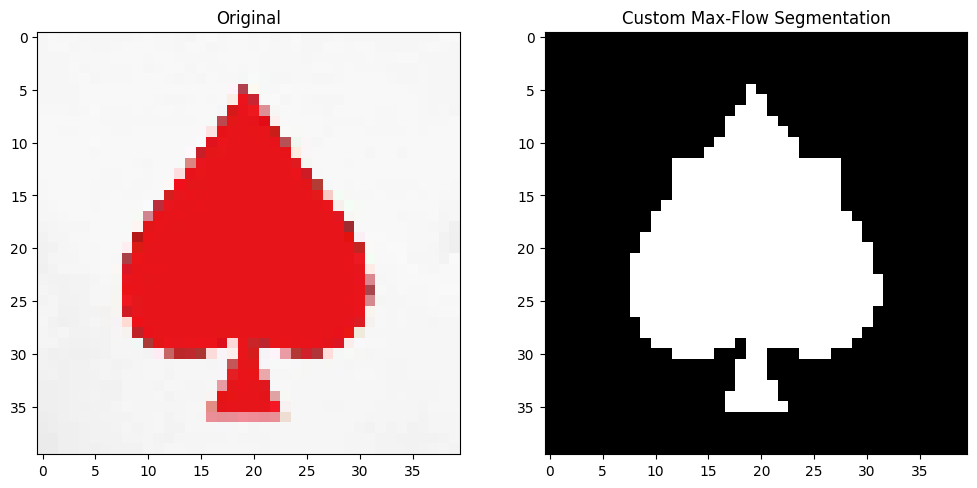

In [19]:
# Retrieve the partition (Foreground pixels)
fg_partition = g.find_min_cut_partition(SOURCE_NODE)

result_mask = np.zeros((h, w), dtype=np.uint8)
for y in range(h):
    for x in range(w):
        u = get_id(y, x)
        if u in fg_partition:
            result_mask[y, x] = 1

# Display
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].set_title("Original")
ax[1].imshow(result_mask, cmap='gray')
ax[1].set_title("Custom Max-Flow Segmentation")
plt.show()

In [20]:
def run_algo_experiment(img, mask, lambda_val, sigma_val):
    """
    Constructs the graph with specific edge capacities (Lambda/Sigma)
    and returns the Min-Cut Partition and the Max-Flow Value.
    """
    h, w, _ = img.shape
    
    # Graph IDs
    SOURCE_NODE = h * w
    SINK_NODE = SOURCE_NODE + 1
    NUM_NODES = SINK_NODE + 2
    
    g = MaxFlowGraph(NUM_NODES)
    
    # Helper to flatten coordinates
    def get_id(y, x): return y * w + x

    # Pre-calculate means for Data Term (Terminal Capacities)
    obj_pixels = img[mask == 2]
    bkg_pixels = img[mask == 1]
    # Handle edge cases if seeds are missing
    mean_obj = np.mean(obj_pixels, axis=0) if len(obj_pixels) > 0 else np.array([0,0,0])
    mean_bkg = np.mean(bkg_pixels, axis=0) if len(bkg_pixels) > 0 else np.array([255,255,255])
    
    # Hard Constraint Cost (Infinity Proxy)
    K = 10000 

    # Build Graph
    for y in range(h):
        for x in range(w):
            u = get_id(y, x)
            
            # --- 1. T-LINKS (Terminal Capacities) ---
            # These represent the "Data Cost"
            if mask[y, x] == 2: # Object Seed
                g.add_edge(SOURCE_NODE, u, K)
                g.add_edge(u, SINK_NODE, 0)
            elif mask[y, x] == 1: # Background Seed
                g.add_edge(SOURCE_NODE, u, 0)
                g.add_edge(u, SINK_NODE, K)
            else:
                # Unknown region
                color = img[y, x]
                dist_obj = np.linalg.norm(color - mean_obj)
                dist_bkg = np.linalg.norm(color - mean_bkg)
                
                # Note: Lambda does NOT multiply these. 
                # This isolates Lambda's effect to the internal graph structure only.
                w_source = 100 / (1 + dist_obj)
                w_sink   = 100 / (1 + dist_bkg)
                
                g.add_edge(SOURCE_NODE, u, w_source)
                g.add_edge(u, SINK_NODE, w_sink)
            
            # --- 2. N-LINKS (Neighbor Capacities) ---
            # These represent the "Topology Cost"
            neighbors = []
            if x < w - 1: neighbors.append(((y, x+1), get_id(y, x+1))) # Right
            if y < h - 1: neighbors.append(((y+1, x), get_id(y+1, x))) # Down
            
            for (ny, nx_coord), v in neighbors:
                diff = np.linalg.norm(img[y, x].astype(float) - img[ny, nx_coord].astype(float))
                
                # ALGORITHMIC LOGIC:
                # Capacity = Coupling_Strength * Decay_Function(Difference)
                capacity = lambda_val * np.exp(- (diff**2) / (2 * sigma_val**2))
                
                # Add bidirectional edges
                g.add_edge(u, v, capacity)
                g.add_edge(v, u, capacity)
                
    # --- 3. Run Max-Flow Algorithm ---
    max_flow_value = g.edmonds_karp(SOURCE_NODE, SINK_NODE)
    
    # --- 4. Retrieve Partition ---
    partition = g.find_min_cut_partition(SOURCE_NODE)
    
    # Reconstruct Mask from partition
    res_mask = np.zeros((h, w), dtype=np.uint8)
    for y in range(h):
        for x in range(w):
            if get_id(y, x) in partition:
                res_mask[y, x] = 1
                
    return res_mask, max_flow_value

In [21]:
print("Starting Comparative Experiment...")

# We compare 3 distinct graph states:
# 1. Zero Coupling: Nodes are independent.
# 2. Weak Coupling: Neighbors have weak influence.
# 3. Strong Coupling: Neighbors are tightly bound.
experiments = [
    {"lam": 0.0, "sig": 10, "desc": "Zero Coupling (Lambda=0)"},
    {"lam": 20.0,  "sig": 10, "desc": "Weak Coupling (Lambda=20)"},
    {"lam": 200.0, "sig": 10, "desc": "Strong Coupling (Lambda=200)"}
]

results = []

for exp in experiments:
    print(f"Running: {exp['desc']}...")
    t0 = time.time()
    
    # Run the wrapper function
    mask_res, flow_val = run_algo_experiment(img, mask, exp['lam'], exp['sig'])
    
    t1 = time.time()
    results.append((mask_res, flow_val, t1-t0))

print("Experiments complete.")

Starting Comparative Experiment...
Running: Zero Coupling (Lambda=0)...
Running: Weak Coupling (Lambda=20)...
Running: Strong Coupling (Lambda=200)...
Experiments complete.


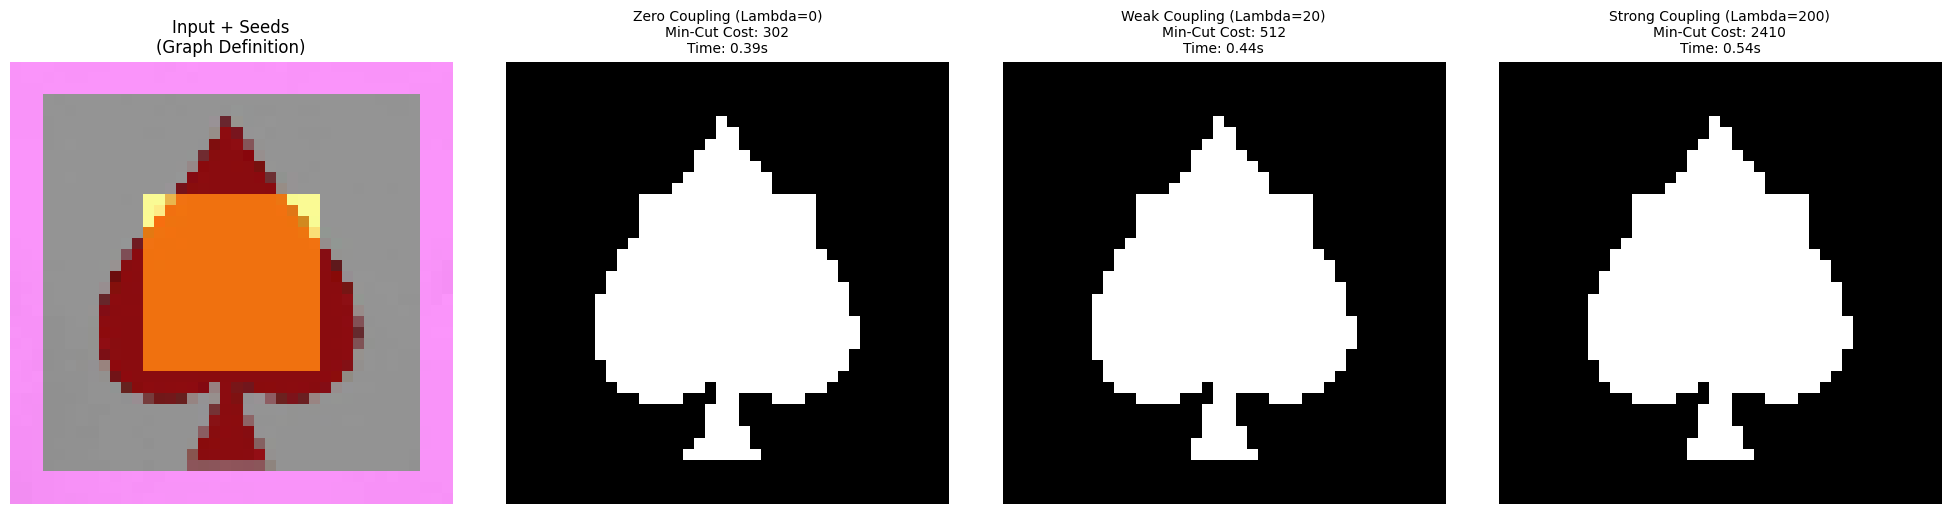

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 1. Show Input with Seeds
axes[0].imshow(img)
seed_overlay = np.zeros_like(img)
seed_overlay[mask == 1] = [255, 0, 255] # Pink BG seeds
seed_overlay[mask == 2] = [255, 255, 0] # Yellow Obj seeds
axes[0].imshow(seed_overlay, alpha=0.4)
axes[0].set_title("Input + Seeds\n(Graph Definition)")
axes[0].axis('off')

# 2. Show Experiment Results
for i, (res_mask, flow_val, duration) in enumerate(results):
    ax = axes[i+1]
    ax.imshow(res_mask, cmap='gray')
    
    exp = experiments[i]
    title = f"{exp['desc']}\nMin-Cut Cost: {flow_val:.0f}\nTime: {duration:.2f}s"
    ax.set_title(title, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [35]:
# ============================
# SEGMENT ONE IMAGE (K-means SEEDS)
# ============================

def segment_one_image(image_path):
    """
    Uses K-means (k=2) to generate foreground/background seeds
    automatically, then runs your same max-flow/min-cut pipeline.
    """

    # Load image
    img_original = cv2.imread(image_path)
    if img_original is None:
        print("Skipping unreadable image:", image_path)
        return None, None, None

    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img_original, (40, 40))  # same as your main demo

    h, w = img.shape[:2]

    # ----------------------------
    # K-MEANS SEED GENERATION
    # ----------------------------
    pixels = img.reshape(-1, 3).astype(np.float32)

    # KMeans criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)

    # Run k-means
    _, labels, centers = cv2.kmeans(
        pixels,
        2,
        None,
        criteria,
        10,
        cv2.KMEANS_RANDOM_CENTERS
    )

    labels = labels.reshape(h, w)

    # Heuristic: brighter cluster → foreground (optional but effective)
    cluster_means = centers.mean(axis=1)
    fg_cluster = np.argmax(cluster_means)
    bg_cluster = 1 - fg_cluster

    # Create seed mask
    # 1 = background, 2 = foreground
    mask = np.zeros((h, w), dtype=np.int8)
    mask[labels == fg_cluster] = 2
    mask[labels == bg_cluster] = 1

    # ----------------------------
    # Run your existing pipeline
    # ----------------------------
    res_mask, flow_val = run_algo_experiment(
        img,
        mask,
        lambda_val = 50,
        sigma_val = 10
    )

    return img, res_mask, flow_val


In [36]:
# =======================================
# RUN SEGMENTATION ON A DATASET OF IMAGES
# =======================================

import os

def segment_dataset(folder_path, output_folder="output_segmentations"):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):

            print("Processing:", filename)
            path = os.path.join(folder_path, filename)

            img, mask, flow_val = segment_one_image(path)

            if img is None:
                continue  # unreadable image

            out_name = filename.rsplit(".", 1)[0] + "_mask.png"
            out_path = os.path.join(output_folder, out_name)

            cv2.imwrite(out_path, (mask * 255).astype("uint8"))
            print(f"→ Saved {out_name}")

    print("\n== All dataset images processed! ==")


In [37]:
segment_dataset("my_images/")


Processing: img10.jpg
→ Saved img10_mask.png
Processing: img11.jpg
→ Saved img11_mask.png
Processing: img12.jpg
→ Saved img12_mask.png
Processing: img13.jpg
→ Saved img13_mask.png
Processing: img14.jpg
→ Saved img14_mask.png
Processing: img15.jpg
→ Saved img15_mask.png
Processing: img16.jpg
→ Saved img16_mask.png
Processing: img17.jpg
→ Saved img17_mask.png
Processing: img18.jpg
→ Saved img18_mask.png
Processing: img19.jpg
→ Saved img19_mask.png
Processing: img2.jpg
→ Saved img2_mask.png
Processing: img20.jpg
→ Saved img20_mask.png
Processing: img21.jpg
→ Saved img21_mask.png
Processing: img3.jpg
→ Saved img3_mask.png
Processing: img4.jpg
→ Saved img4_mask.png
Processing: img5.jpg
→ Saved img5_mask.png
Processing: img6.jpg
→ Saved img6_mask.png
Processing: img7.jpg
→ Saved img7_mask.png
Processing: img8.jpg
→ Saved img8_mask.png
Processing: img9.jpg
→ Saved img9_mask.png

== All dataset images processed! ==


In [30]:
import cv2
import os

for f in os.listdir("my_images/"):
    path = os.path.join("my_images", f)
    img = cv2.imread(path)
    print(f, " -> ", "OK" if img is not None else "FAILED")


img10.jpg  ->  OK
img11.jpg  ->  OK
img12.jpg  ->  OK
img13.jpg  ->  OK
img14.jpg  ->  OK
img15.jpg  ->  OK
img16.jpg  ->  OK
img17.jpg  ->  OK
img18.jpg  ->  OK
img19.jpg  ->  OK
img2.jpg  ->  OK
img20.jpg  ->  OK
img21.jpg  ->  OK
img3.jpg  ->  OK
img4.jpg  ->  OK
img5.jpg  ->  OK
img6.jpg  ->  OK
img7.jpg  ->  OK
img8.jpg  ->  OK
img9.jpg  ->  OK
